In [1]:
# import the libraries. Also "punkt" and "averaged_perception_tagger" are downloaded for later usage, dealing with text.
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re, string
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import spacy

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\klnde\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\klnde\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Number of characters on the dataframe is set to 100
pd.set_option('display.max_colwidth', 100)

# import the files as pandas dataframe. Dataframes are easy to read and we can use certain functions 
#and attributes to know more characteristics.
sample_df = pd.read_csv(r'C:\Users\klnde\Desktop\DSE\sample_submission.csv')
train_df = pd.read_csv(r'C:\Users\klnde\Desktop\DSE\train.csv')
test_df = pd.read_csv(r'C:\Users\klnde\Desktop\DSE\test.csv')

In [3]:
# check the dataframe sample_df 
sample_df.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [4]:
# check the shape
sample_df.shape

(3263, 2)

In [5]:
# check for the missing data
sample_df.isnull().sum()

id        0
target    0
dtype: int64

In [6]:
# check train_df
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [7]:
# check the shape
train_df.shape

(7613, 5)

In [8]:
# check for the missing data
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
# check for any duplicated data. 
train_df.duplicated().sum()

0

In [10]:
# check test_df
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [11]:
# check the shape
test_df.shape

(3263, 4)

In [12]:
# check the missing data
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [13]:
# check the duplicated data
test_df.duplicated().sum()

0

Let us check for the distribution of data regarading whether the proportion of labeled tweets disaster or non-disaster. 
It gives an indication of howmuch data is biased.

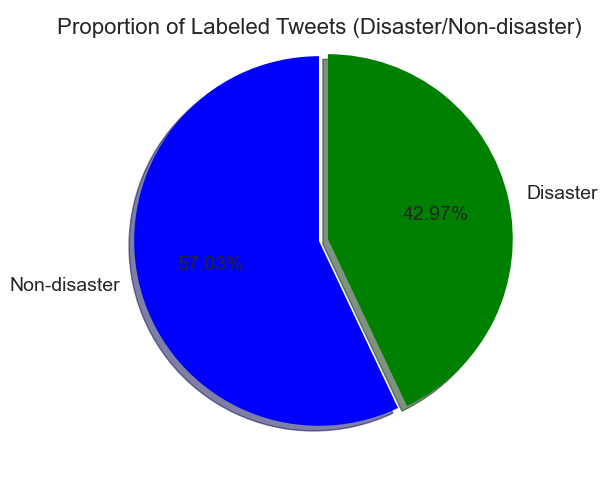

In [14]:
# set the figure size
plt.figure(figsize=(10, 6))

# set the style
plt.style.use('seaborn-darkgrid')

# set the colors
colors = ['blue', 'green']

# generate a pie plot
plt.pie(train_df['target'].value_counts(), explode=(0, 0.05), labels=["Non-disaster", "Disaster"], 
        autopct="%0.2f%%", textprops={'fontsize': 14}, shadow=True, startangle=90, colors=colors)

# add a title
plt.title('Proportion of Labeled Tweets (Disaster/Non-disaster)', size=16, y=0.93)

# show the plot
plt.show()

The given dataset is well-balanced. Both categories (disaster and non-disaster) are nearly close to 50%.

Word Clouds Using Unprocessed Text
Let us visualize the unprocessed text as a word cloud. The size of text shows the frequency 
that the word appears in the dataset.

In [15]:
# set the random state
random_state = 2048

# import the wordcloud library
from wordcloud import WordCloud

# concat all the text for each labels
non_disaster_text = [''.join(t) for t in train_df[train_df['target']==0]['text']]
non_disaster_strings = ' '.join(map(str, non_disaster_text))
disaster_text = [''.join(t) for t in train_df[train_df['target']==1]['text']]
disaster_strings = ' '.join(map(str, disaster_text))

# generate word clouds
non_disaster_cloud = WordCloud(width=800, height=400, max_words=500, background_color='white', random_state=random_state).generate(non_disaster_strings)
disaster_cloud = WordCloud(width=800, height=400, max_words=500, random_state=random_state).generate(disaster_strings)

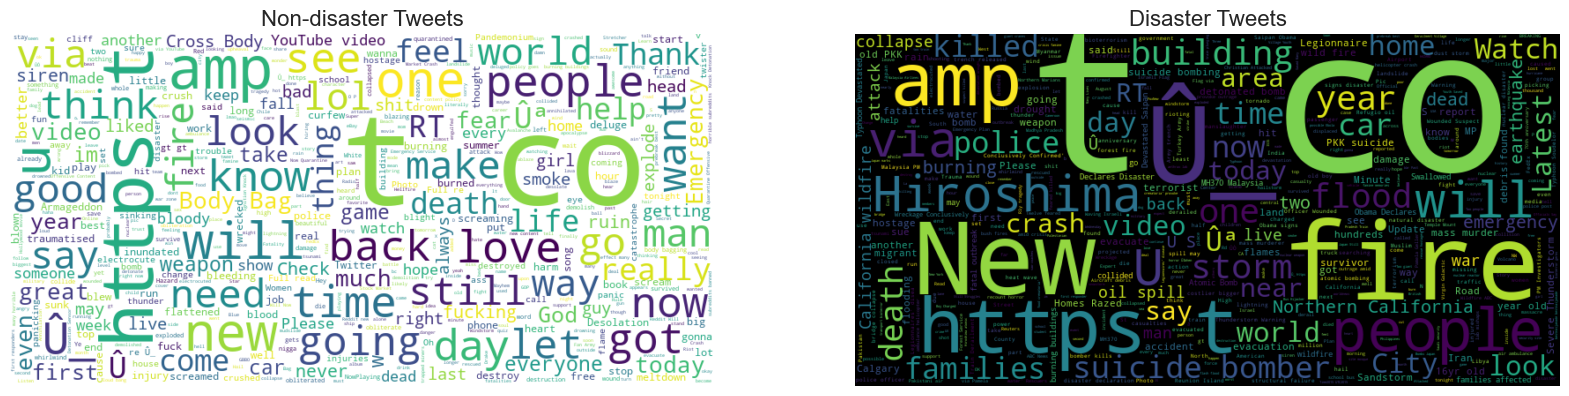

In [16]:
# create subplots for the generated clouds

fig, axes = plt.subplots(1, 2, figsize = (20,20))
axes[0].imshow(non_disaster_cloud, interpolation='bilinear')
axes[1].imshow(disaster_cloud, interpolation='bilinear')

# turn the axis off
[ax.axis('off') for ax in axes]

# add titles
axes[0].set_title('Non-disaster Tweets', fontsize=16)
axes[1].set_title('Disaster Tweets', fontsize=16)

# show the figure
plt.show()

Let us now start preprocessing the text by removing the (i) URLs, (ii) HTML tags, (iii)character references, 
(iv) non-printable characters, and (v) numeric values. 

In [17]:
# defining a function that removes URLs from the text

def remove_url(text):
    text = re.sub(r'((?:https?|ftp|file)://[-\w\d+=&@#/%?~|!:;\.,]*)', '', text)
    return text

# remove URLs from the text and show the modified text in a new column

train_df['text_cleaned'] = train_df['text'].apply(remove_url)
test_df['text_cleaned'] = test_df['text'].apply(remove_url)

In [18]:
# define a function that removes HTML tags

def remove_HTML(text):
    text = re.sub(r'<.*?>', '', text)
    return text

# remove HTML tags

train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_HTML)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_HTML)

In [19]:
# define a function to remove character references (e.g., &lt;, &amp;, &nbsp;)

def remove_references(text):
    text = re.sub(r'&[a-zA-Z]+;?', '', text)
    return text

# remove character references

train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_references)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_references)

In [20]:
# check which characters are printable (ASCII)

string.printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [21]:
# define a function that removes non-printable characters

def remove_non_printable(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

#remove non-printable characters
train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_non_printable)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_non_printable)

In [22]:
# define a function that removes numeric values and mixtures

def remove_num(text):
    text = re.sub(r'\w*\d+\w*', '', text)
    return text

# remove numeric values and mixtures
train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_num)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_num)

In [23]:
# check the results

train_df.tail()

,id,keyword,location,text,target,text_cleaned
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,Two giant cranes holding a bridge collapse into nearby homes
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part ...,1,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part ...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,. [: UTC]? S of Volcano Hawaii.
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffer...,1,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffer...
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d,1,The Latest: More Homes Razed by Northern California Wildfire - ABC News


In [24]:
# check the results

test_df.tail()

,id,keyword,location,text,text_cleaned
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn,EARTHQUAKE SAFETY LOS ANGELES SAFETY FASTENERS XrWn
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it wa...,Storm in RI worse than last hurricane. My hardest hit. My yard looks like it was bombed. Around...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/UtbXLcBIuY,Green Line derailment in Chicago
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3,MEG issues Hazardous Weather Outlook (HWO)
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm,#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm


Now let us lemmatize (converting into baseform of text) and change the case (to lower) for our text, 
and remove repeated characters if there are any in elongated words, stopwords, and punctuation. We create features including (i) number of words, (ii) number of sentences, (iii) number of characters, (iv) number of hashtags, (v)number of mentions, (vi) number of all caps words, (vii) average length of words, (viii) number of proper nouns (PROPN), and (ix) number of non-proper nouns (NOUN), and (x) percentage of characters that are punctuation.

In [25]:
# A new feature for the number of words

train_df['word_count'] = train_df['text'].apply(nltk.tokenize.word_tokenize).apply(len)
test_df['word_count'] = test_df['text'].apply(nltk.tokenize.word_tokenize).apply(len)

In [26]:
# A new feature for number of sentences

train_df['sent_count'] = train_df['text'].apply(nltk.tokenize.sent_tokenize).apply(len)
test_df['sent_count'] = test_df['text'].apply(nltk.tokenize.sent_tokenize).apply(len)

In [27]:
# create a new feature for the number of characters (excluding white spaces)

train_df['char_count'] = train_df['text'].apply(lambda x: len(x) - x.count(" "))
test_df['char_count'] = test_df['text'].apply(lambda x: len(x) - x.count(" "))

In [28]:
# define a function that returns the number of hashtags in a string

def hash_count(string):
    words = string.split()
    hashtags = [w for w in words if w.startswith('#')]
    return len(hashtags)

# create a new feature for the number of hashtags

train_df['hash_count'] = train_df['text'].apply(hash_count)
test_df['hash_count'] = test_df['text'].apply(hash_count)

In [29]:
# define a function that returns the number of mentions in a string

def ment_count(string):
    words = string.split()
    mentions = [w for w in words if w.startswith('@')]
    return len(mentions)

# create a new feature for the number of mentions

train_df['ment_count'] = train_df['text'].apply(ment_count)
test_df['ment_count'] = test_df['text'].apply(ment_count)

In [30]:
# define a function that returns the number of words in all CAPS

def all_caps_count(string):
    words = string.split()
    pattern = re.compile(r'\b[A-Z]+[A-Z]+\b')
    capsWords = [w for w in words if w in re.findall(pattern, string)]
    return len(capsWords)

# create a new feature for the number of words in all CAPS

train_df['all_caps_count'] = train_df['text'].apply(all_caps_count)
test_df['all_caps_count'] = test_df['text'].apply(all_caps_count)


In [31]:
# define a function that returns the average length of words

def avg_word_len(string):
    words = string.split()
    total_len = sum([len(words[i]) for i in range(len(words))])
    avg_len = round(total_len / len(words), 2)
    return avg_len

# create a new feature for the average length of words

train_df['avg_word_len'] = train_df['text'].apply(avg_word_len)
test_df['avg_word_len'] = test_df['text'].apply(avg_word_len)

In [32]:
# define a function using nltk that returns the number of proper nouns in the text

def propn_count_nltk(text):    
    tokens = nltk.word_tokenize(text)
    tagged = [token for token in nltk.pos_tag(tokens)]
    propn_count = len([token for (token, tag) in tagged if tag == 'NNP' or tag == 'NNPS'])
    return propn_count

# create a new feature for the number of proper nouns

train_df['propn_count_nltk'] = train_df['text'].apply(propn_count_nltk)
test_df['propn_count_nltk'] = test_df['text'].apply(propn_count_nltk)

In [33]:
# check the results using .head()

train_df[['id', 'text', 'text_cleaned', 'propn_count_nltk']].head()

,id,text,text_cleaned,propn_count_nltk
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,4
1,4,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,5
2,5,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,0
3,6,"13,000 people receive #wildfires evacuation orders in California",", people receive #wildfires evacuation orders in California",1
4,7,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,2


Summary of results tell us that "nltk" did not do a good job in detecting proper nouns the first sentence , for example. 
The first text, "Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all" doesn't seem to have 
all 4 proper nouns. Let us check which tokens were tagged as proper nouns. 

In [34]:
# test how nltk worked with the first text

string = "Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all"
print([(token, tag) for (token, tag) in nltk.pos_tag(nltk.word_tokenize(string)) if tag == 'NNP'])

[('Reason', 'NNP'), ('May', 'NNP'), ('ALLAH', 'NNP'), ('Forgive', 'NNP')]


Non-proper nouns that begin with an uppercase letter were tagged as proper-nouns.
If the string was converted to lowercase, then it Would have correctly tagged. 

In [35]:
# test how nltk works with the first text after lowercasing it

string = "Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all"
print([(token, tag) for (token, tag) in nltk.pos_tag(nltk.word_tokenize(string.lower())) if tag == 'NNP'])

[]


This time with the lowercased text, "nltk" did not tag "allah" as a proper noun. 
Let's try with spacy. 

In [36]:
# load the model
nlp = spacy.load('en_core_web_sm')

# check the same string with spacy
string = "Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all"
print([(token.text, token.pos_) for token in nlp(string) if token.pos_=='PROPN'])

[('ALLAH', 'PROPN')]


Spacy correctly picked up the proper noun from the string. Let us create the feature of the number of proper nouns 
in the text with spacy and remove the one we previously created with "nltk".

In [37]:
# defining a function that returns number of proper nouns with spacy

def propn_count(text, model=nlp):
    doc = model(text)
    pos = [token.pos_ for token in doc]
    return pos.count('PROPN')

# creating a new feature for numbers of proper nouns

train_df['propn_count'] = train_df['text'].apply(propn_count)
test_df['propn_count'] = test_df['text'].apply(propn_count)

In [38]:
# removing 'propn_count_nltk' columns

train_df = train_df.drop(['propn_count_nltk'], axis=1)
test_df = test_df.drop(['propn_count_nltk'], axis=1)

In [39]:
# checking the results using .head()function

train_df[['id', 'text', 'text_cleaned', 'propn_count']].head()

,id,text,text_cleaned,propn_count
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,4
2,5,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,0
3,6,"13,000 people receive #wildfires evacuation orders in California",", people receive #wildfires evacuation orders in California",1
4,7,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,2


Spacy seemed perfect, but not. "La Ronge" in the second text (id:4) is one proper noun.
But spacy is better than nltk on this specific task in terms of performance. Let us use spacy for the next feature 
as well.

In [40]:
# Number of Non-proper Nouns (NOUN)
# define a function that returns number of non-proper nouns

def noun_count(text, model=nlp):
    doc = model(text)
    pos = [token.pos_ for token in doc]
    return pos.count('NOUN')

# create a new feature for numbers of non-proper nouns

train_df['noun_count'] = train_df['text'].apply(noun_count)
test_df['noun_count'] = test_df['text'].apply(noun_count)

Percentage of characters that are punctuation

In [41]:
import string

# define a function that returns the percentage of punctuation
def punc_per(text):
    total_count = len(text) - text.count(" ")
    punc_count = sum([1 for c in text if c in string.punctuation])
    if punc_count != 0 and total_count != 0:
        return round(punc_count / total_count * 100, 2)
    else:
        return 0

# create a new feature for the percentage of punctuation in text
train_df['punc_per'] = train_df['text'].apply(punc_per)
test_df['punc_per'] = test_df['text'].apply(punc_per)

In [42]:
# check the results

train_df.tail()

,id,keyword,location,text,target,text_cleaned,word_count,sent_count,char_count,hash_count,ment_count,all_caps_count,avg_word_len,propn_count,noun_count,punc_per
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,Two giant cranes holding a bridge collapse into nearby homes,13,1,73,0,0,0,6.64,0,5,6.85
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part ...,1,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part ...,24,2,106,0,2,0,5.30,1,3,4.72
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,. [: UTC]? S of Volcano Hawaii.,15,2,58,0,0,0,7.25,5,2,18.97
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffer...,1,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffer...,21,2,119,0,0,0,6.26,2,8,4.20
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d,1,The Latest: More Homes Razed by Northern California Wildfire - ABC News,16,1,82,0,0,1,6.31,5,2,8.54


In [43]:
# check the results
test_df.tail()

,id,keyword,location,text,text_cleaned,word_count,sent_count,char_count,hash_count,ment_count,all_caps_count,avg_word_len,propn_count,noun_count,punc_per
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn,EARTHQUAKE SAFETY LOS ANGELES SAFETY FASTENERS XrWn,8,1,48,0,0,6,6.00,5,1,0.00
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it wa...,Storm in RI worse than last hurricane. My hardest hit. My yard looks like it was bombed. Around...,30,4,117,0,0,1,5.09,1,6,4.27
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/UtbXLcBIuY,Green Line derailment in Chicago,8,1,50,0,0,0,8.33,3,2,10.00
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3,MEG issues Hazardous Weather Outlook (HWO),11,1,59,0,0,1,8.43,5,2,11.86
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm,#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm,11,2,61,2,0,0,7.62,4,0,4.92


Let us now text preprocess the data, lemmatize and convert to lowercase. Also, we remove repeated characters 
in elongated words, as well as mentions, stopwords, and punctuation. We keep keep hashtags as they may provide 
valuable insights at later stages. 

In [44]:
# lemmatize the text

train_df['text_cleaned'] = train_df['text_cleaned'].apply(lambda x:' '.join([t.lemma_ for t in nlp(x)]))
test_df['text_cleaned'] = test_df['text_cleaned'].apply(lambda x:' '.join([t.lemma_ for t in nlp(x)]))

In [45]:
# lowercase the text

train_df['text_cleaned'] = [t.lower() for t in train_df['text_cleaned']]
test_df['text_cleaned'] = [t.lower() for t in test_df['text_cleaned']]

In [46]:
# define a function that removes repeated characters in elongated words

def remove_repeated(text):
    elongated = re.compile(r'(\S*?)([a-z])\2{2,}')
    text = elongated.sub(r'\1\2', text)
    return text

# remove repeated characters in elongated words

train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_repeated)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_repeated)

In [47]:
# define a function that removes mentions

def remove_mention(text):
    text = re.sub(r'@\w+', '', text)
    return text

# remove mentions

train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_mention)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_mention)

In [48]:
# define a function that removes stopwords

def remove_stopwords(text):
    stopwords = nlp.Defaults.stop_words
    text_nostop = ' '.join([token for token in text.split() if token not in stopwords])
    return text_nostop

# remove stopwords

train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_stopwords)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_stopwords)

In [49]:
# define a function to remove punctuation

def remove_punct(text):
    punct = string.punctuation
    text_nospunct = ' '.join([token for token in text.split() if token not in punct])
    return text_nospunct

# remove punctuation

train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_punct)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_punct)

In [50]:
# check the results using .head()

train_df[['id', 'text', 'text_cleaned']].head()

,id,text,text_cleaned
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,deed reason earthquake allah forgive
1,4,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,resident ask shelter place notify officer evacuation shelter place order expect
3,6,"13,000 people receive #wildfires evacuation orders in California",people receive wildfire evacuation order california
4,7,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,got send photo ruby alaska smoke wildfire pour school


In [51]:
# check the results using .head()

test_df[['id', 'text', 'text_cleaned']].head()

,id,text,text_cleaned
0,0,Just happened a terrible car crash,happen terrible car crash
1,2,"Heard about #earthquake is different cities, stay safe everyone.",hear earthquake different city stay safe
2,3,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",forest fire spot pond geese flee street save
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


Let us check for raw and preprocessed Text with Word clouds
Also, let us generate word clouds of preprocessed text.

In [52]:
# concating all the preprocessed text for both labels

non_disaster_processed = [''.join(t) for t in train_df[train_df['target']==0]['text_cleaned']]
non_disaster_processed_s = ' '.join(map(str, non_disaster_processed))
disaster_processed = [''.join(t) for t in train_df[train_df['target']==1]['text_cleaned']]
disaster_processed_s = ' '.join(map(str, disaster_processed))

# generating word clouds of the preprocessed text

non_disaster_processed_wc = WordCloud(width=800, height=400, max_words=500, background_color='white', random_state=random_state).generate(non_disaster_processed_s)
disaster_processed_wc = WordCloud(width=800, height=400, max_words=500, random_state=random_state).generate(disaster_processed_s)

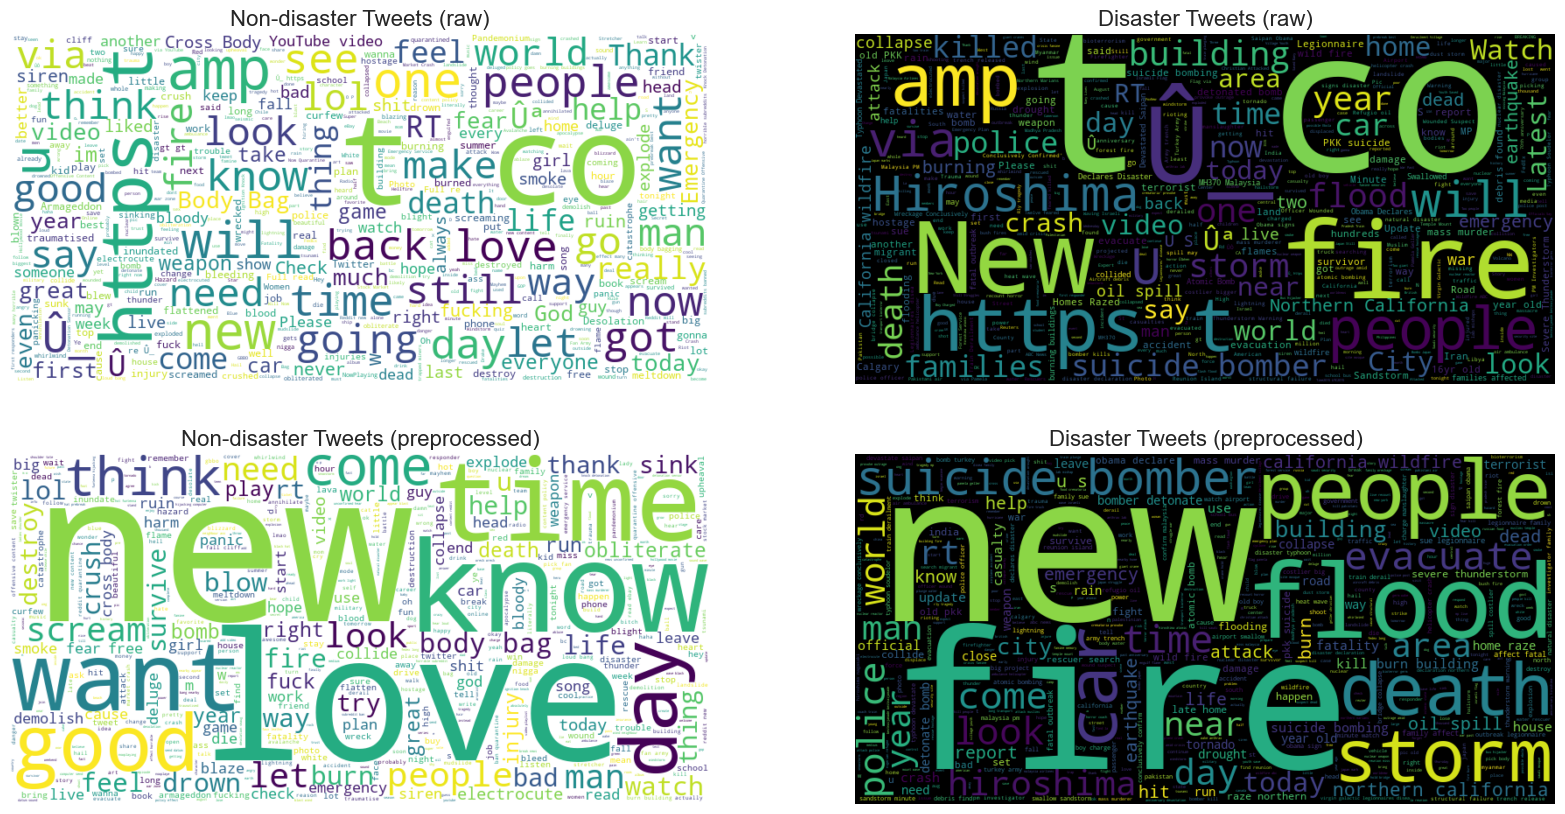

In [53]:
# create subplots for the generated clouds

fig, axes = plt.subplots(2, 2, figsize = (20,10))
axes[0,0].imshow(non_disaster_cloud, interpolation='bilinear')
axes[0,1].imshow(disaster_cloud, interpolation='bilinear')
axes[1,0].imshow(non_disaster_processed_wc, interpolation='bilinear')
axes[1,1].imshow(disaster_processed_wc, interpolation='bilinear')

# turn the axis off
[ax.axis('off') for ax in axes.ravel()]

# add titles
axes[0,0].set_title('Non-disaster Tweets (raw)', fontsize=16)
axes[0,1].set_title('Disaster Tweets (raw)', fontsize=16)
axes[1,0].set_title('Non-disaster Tweets (preprocessed)', fontsize=16)
axes[1,1].set_title('Disaster Tweets (preprocessed)', fontsize=16)

# show the figure
plt.show()

Let us see the frequently used words that are meaningful. 
It also seems like more disaster-related words are showing on the word cloud of real disaster Tweets.
Visualizing Differences: 
Visualize some of the features that have been created. Check if there are easy-to-tell differences 
between disaster and non-disaster Tweets in our training dataset.

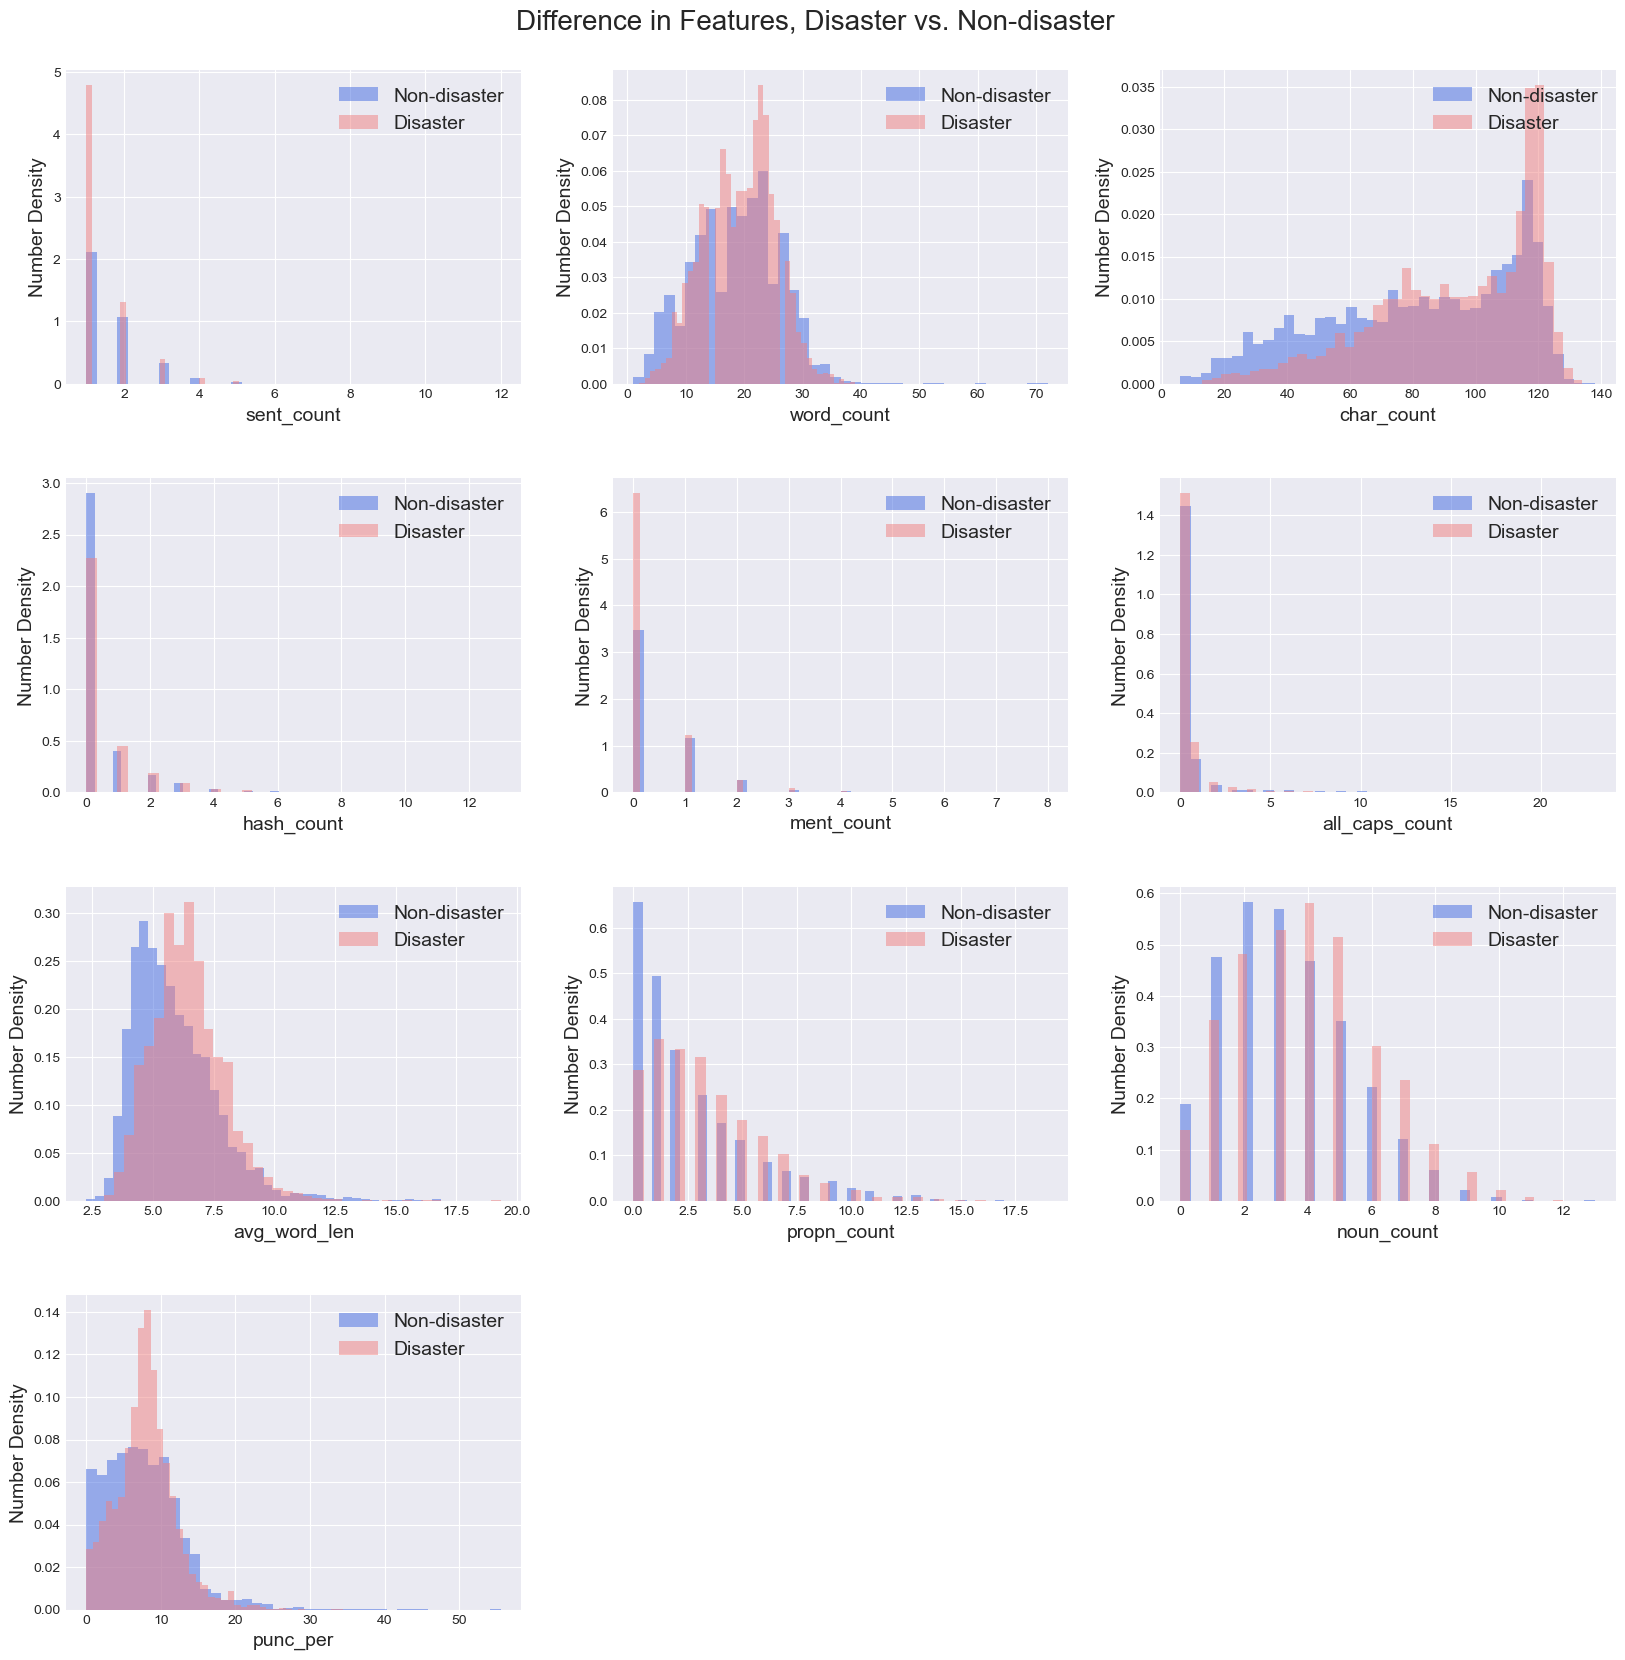

In [54]:
# store the features and their names in variables
features = ['sent_count', 'word_count', 'char_count', 'hash_count', 'ment_count', 'all_caps_count', 
            'avg_word_len', 'propn_count', 'noun_count', 'punc_per']

# create the figure
fig = plt.figure(figsize=(20, 20))

# adjust the height of the padding between subplots to avoid overlapping
plt.subplots_adjust(hspace=0.3)

# add a centered suptitle to the figure
plt.suptitle("Difference in Features, Disaster vs. Non-disaster", fontsize=20, y=0.91)

# generate the histograms in a for loop
for i, feature in enumerate(features):
    
    # add a new subplot iteratively
    ax = plt.subplot(4, 3, i+1)
    ax = train_df[train_df['target']==0][feature].hist(alpha=0.5, label='Non-disaster', bins=40, color='royalblue', density=True)
    ax = train_df[train_df['target']==1][feature].hist(alpha=0.5, label='Disaster', bins=40, color='lightcoral', density=True)
    
    # set x_label, y_label, and legend. Number density defines the count histogram, whether it is disaster/non-disaster.
    ax.set_xlabel(features[i], fontsize=14)
    ax.set_ylabel('Number Density', fontsize=14)
    ax.legend(loc='upper right', fontsize=14)
    

# shot the figure
plt.show()

Model Building:
Vectorizing Text & Selecting Input/Output

In [55]:
# import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# instantiate the vectorizer
tfidf = TfidfVectorizer()

# fit and transform
X_tfidf = tfidf.fit_transform(train_df['text_cleaned'])

In [56]:
# create a dataframe from the sparse matrix
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())

# check the dataframe
X_tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,12039,12040,12041,12042,12043,12044,12045,12046,12047,12048
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
# Let us get the feature names from our stored vectorizer and assign them to X_tfidf_df
# to avoid getting 'FutureWarning: Feature names only support names that are strings.'
X_tfidf_df.columns = tfidf.get_feature_names_out()

# check the column names
X_tfidf_df.columns

Index(['__', 'aa', 'aan', 'aand', 'aar', 'aashiqui', 'ab', 'aba', 'abandon',
       'abandoned',
       ...
       'zombie', 'zone', 'zones', 'zoom', 'zotar', 'zouma', 'zrnf', 'zss',
       'zumiez', 'zurich'],
      dtype='object', length=12049)

In [58]:
# create the new dataframe, X_features
X_features = pd.concat([train_df[['word_count', 'char_count', 'avg_word_len', 'punc_per']],
                        X_tfidf_df], axis=1)

# check the shape
X_features.shape

(7613, 12053)

In [59]:
# check the dataframe
X_features.head()

,word_count,char_count,avg_word_len,punc_per,__,aa,aan,aand,aar,aashiqui,...,zombie,zone,zones,zoom,zotar,zouma,zrnf,zss,zumiez,zurich
0,14,57,4.38,1.75,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8,32,4.57,3.12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,24,112,5.09,2.68,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,57,7.12,3.51,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18,72,4.50,2.78,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Splitting the data into Train and Validation Data:
We will split our preprocessed training dataset into training subset and validation subset. 
The former will be used to train our models, while as the latter is heldout for validation.

In [60]:
# import the library
from sklearn.model_selection import train_test_split

# select the input/output
X = X_features
y = train_df['target']

# split the data
# the names, X_val and y_val, are used instead of X_test and y_test to avoid confusion with our actual test data
# which we will be using to make the predictions with the selected model at the end of this notebook
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [61]:
#Building Models:
# import the libraries
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [62]:
# create a dictionary containing the names and code of algorithms
clfs = {'mnb': MultinomialNB(), 
        'svc': SVC(random_state=random_state), 
        'lr': LogisticRegression(max_iter=10000, random_state=random_state), 
        'dtc': DecisionTreeClassifier(random_state=random_state),
        'knc': KNeighborsClassifier(n_jobs=-1), 
        'rfc': RandomForestClassifier(random_state=random_state, n_jobs=-1), 
        'gbc': GradientBoostingClassifier(random_state=random_state)}

In [63]:
# create a function that builds and runs multiple classification models

def classify(clf, X_train, X_val, y_train, y_val):
    y_pred = clf.fit(X_train, y_train).predict(X_val)
    precision = precision_score(y_val, y_pred)
    fscore = f1_score(y_val, y_pred)
    train_accuracy = clf.score(X_train, y_train)
    test_accuracy = accuracy_score(y_val, y_pred)
    return precision, fscore, train_accuracy, test_accuracy

In [64]:
# To create lists to store scores to build a dataframe later on
precision_series = []
fscore_series = []
train_accuracy_series = []
test_accuracy_series = []

# run the models with classify() function we created above (this takes some time)
for name, clf in clfs.items():
    i_precision, i_fscore, i_train_accuracy, i_test_accuracy = classify(clf, X_train, X_val, y_train, y_val)
    
    # append the scores to the lists
    precision_series.append(i_precision)
    fscore_series.append(i_fscore)
    train_accuracy_series.append(i_train_accuracy)
    test_accuracy_series.append(i_test_accuracy)
    
    # fit and predict
    y_pred = clf.fit(X_train, y_train).predict(X_val)
    
    # print out the scores and classification reports
    print('[{}]\nPrecision: {} | F1-score: {} | Train Accuracy: {} | Test Accuracy: {}\n'.format(name,
                                                                                                 round(i_precision, 2),
                                                                                                 round(i_fscore, 2),
                                                                                                 round(i_train_accuracy, 2),
                                                                                                 round(i_test_accuracy, 2)))
    print(classification_report(y_val, y_pred))

[mnb]
Precision: 0.86 | F1-score: 0.73 | Train Accuracy: 0.87 | Test Accuracy: 0.8

              precision    recall  f1-score   support

           0       0.78      0.93      0.85       880
           1       0.86      0.63      0.73       643

    accuracy                           0.80      1523
   macro avg       0.82      0.78      0.79      1523
weighted avg       0.81      0.80      0.80      1523

[svc]
Precision: 0.61 | F1-score: 0.59 | Train Accuracy: 0.64 | Test Accuracy: 0.66

              precision    recall  f1-score   support

           0       0.70      0.73      0.72       880
           1       0.61      0.57      0.59       643

    accuracy                           0.66      1523
   macro avg       0.65      0.65      0.65      1523
weighted avg       0.66      0.66      0.66      1523

[lr]
Precision: 0.83 | F1-score: 0.76 | Train Accuracy: 0.88 | Test Accuracy: 0.81

              precision    recall  f1-score   support

           0       0.80      0.89     

Let us check with RandomForestClassifier to compare which features our model found important.

In [65]:
# fit the model
rfc_model = clfs.get('rfc').fit(X_train, y_train)

# check the feature_importances
sorted(zip(rfc_model.feature_importances_, X_train.columns), reverse=True)[0:10]

[(0.03602946032364336, 'avg_word_len'),
 (0.0245716452409329, 'punc_per'),
 (0.023982793197562614, 'char_count'),
 (0.017584437227298858, 'word_count'),
 (0.012031030337646567, 'fire'),
 (0.0068283703186786905, 'kill'),
 (0.006286716976280621, 'hiroshima'),
 (0.005591727080755272, 'california'),
 (0.005487144796021521, 'storm'),
 (0.00538811320050587, 'train')]

All four features that we have created are listed in top 10 most important features by RandomForestClassifier. Let us 
visualize our model performances.

Visualizing Model Performance:

In [66]:
# create a dataframe with the scores
scores_df = pd.DataFrame({'Algorithm': clfs.keys(),
                          'Precision': precision_series,
                          'F1 Score': fscore_series,
                          'Train Accuracy': train_accuracy_series,
                          'Test Accuracy': test_accuracy_series}).round(2).sort_values('Test Accuracy', ascending=False)
# check the dataframe
scores_df

,Algorithm,Precision,F1 Score,Train Accuracy,Test Accuracy
2,lr,0.83,0.76,0.88,0.81
0,mnb,0.86,0.73,0.87,0.80
5,rfc,0.86,0.71,0.99,0.79
6,gbc,0.81,0.66,0.79,0.76
3,dtc,0.63,0.61,0.99,0.68
1,svc,0.61,0.59,0.64,0.66
4,knc,0.59,0.57,0.75,0.65


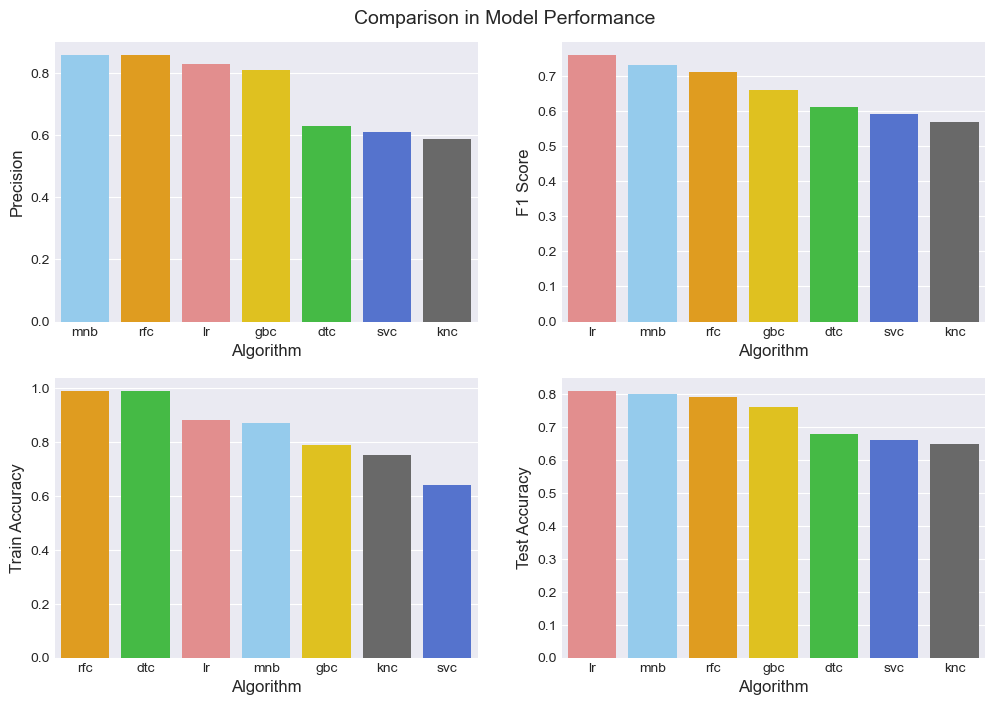

In [67]:
# create a list of metrics
metrics = ['Precision', 'F1 Score', 'Train Accuracy', 'Test Accuracy']

# create the figure
fig = plt.figure(figsize=(12, 8))

# adjust the height of the padding between subplots to avoid overlapping
#plt.subplots_adjust(hspace=0.3)

# set the color palette
colors = {'lr':'lightcoral',
          'mnb':'lightskyblue',
          'rfc':'orange',
          'gbc':'gold',
          'dtc':'limegreen',
          'svc':'royalblue',
          'knc':'dimgray'}

# add a centered suptitle to the figure
plt.suptitle('Comparison in Model Performance', fontsize=14, y=0.92)

# generate the histograms in a for loop
for i, metric in enumerate(metrics):
    
    # add a new subplot iteratively
    ax = plt.subplot(2, 2, i+1)
    ax = sns.barplot(x='Algorithm', y=metric, data=scores_df.sort_values(metric, ascending=False), palette=colors)
    
    # set x_label, y_label
    ax.set_xlabel('Algorithm', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    
# show the plots
plt.show()

Model Evaluation:
Let's perform cross validation and grid search using RandomizedSearchCV on our top 3 models.

In [68]:
# import the libraries
from sklearn.model_selection import RandomizedSearchCV
from time import time

In [69]:
# Linear Regression
# instantiate the model
lr = LogisticRegression(max_iter=10000, random_state=random_state)

# set the parameters
param_lr = {'C': [0.01, 0.1, 1, 10, 100]}

In [70]:
# construct RandomizedSearchCV object

rs_lr = RandomizedSearchCV(lr, param_lr, scoring='accuracy', cv=5, n_iter=5, n_jobs=-1, random_state=random_state)

# check the time
start = time()

# fit the model
rs_lr_fit = rs_lr.fit(X_train, y_train)

# check the time
end = time()

# store the results in a dataframe
rs_rl_df = pd.DataFrame(rs_lr_fit.cv_results_).sort_values('mean_test_score', ascending=False)

# show the top 5 models
rs_rl_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,561.720466,38.613878,3.699053,1.209775,10,{'C': 10},0.790640,0.798030,0.787356,0.788998,0.789819,0.790969,0.003694,1
2,138.916898,15.338227,1.363632,0.502082,1,{'C': 1},0.791461,0.790640,0.782430,0.789819,0.793924,0.789655,0.003865,2
4,1020.168289,172.920762,0.715763,0.379232,100,{'C': 100},0.773399,0.781609,0.766010,0.767652,0.770936,0.771921,0.005481,3
1,92.814758,21.968632,1.159673,0.447969,0.1,{'C': 0.1},0.711823,0.713465,0.699507,0.695402,0.710181,0.706076,0.007232,4
0,107.960666,4.142093,0.903431,0.346591,0.01,{'C': 0.01},0.651888,0.654351,0.630542,0.636289,0.648604,0.644335,0.009280,5


In [71]:
# print out the algorithm, fitting time, best parameters, and best score
print('Logistic Regression:\nProcessing Time: {} secs | Best Parameters: {} | Best Score: {}'.format(round(end-start, 2),
                                                                                                     rs_lr_fit.best_params_, 
                                                                                                     round(rs_lr_fit.best_score_, 2)))

Logistic Regression:
Processing Time: 1659.47 secs | Best Parameters: {'C': 10} | Best Score: 0.79


Multinomial Naive Bayes (mnb):

In [72]:
# instantiate the model
mnb = MultinomialNB()

# set the parameters
param_mnb = {'alpha': [0.0001, 0.001, 0.1, 1, 10, 100,1000]}

In [73]:
# construct RandomizedSearchCV object
rs_mnb = RandomizedSearchCV(mnb, param_mnb, scoring='accuracy', cv=5, n_iter=7, n_jobs=-1, random_state=random_state)

# check the time
start = time()

# fit the model
rs_mnb_fit = rs_mnb.fit(X_train, y_train)

# check the time
end = time()

# store the results in a dataframe
rs_mnb_df = pd.DataFrame(rs_mnb_fit.cv_results_).sort_values('mean_test_score', ascending=False)

# show the top 5 models
rs_mnb_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,1.396141,0.067180,0.375114,0.060129,0.1,{'alpha': 0.1},0.788998,0.786535,0.766831,0.779146,0.774220,0.779146,0.008094,1
3,1.619241,0.314245,0.371988,0.028650,1,{'alpha': 1},0.787356,0.793103,0.779146,0.766831,0.767652,0.778818,0.010445,2
1,1.344711,0.334657,0.370602,0.052816,0.001,{'alpha': 0.001},0.766010,0.769294,0.745484,0.766831,0.762726,0.762069,0.008554,3
0,6.354985,0.336277,1.078904,0.985127,0.0001,{'alpha': 0.0001},0.761905,0.766010,0.743021,0.764368,0.759442,0.758949,0.008269,4
4,1.634869,0.042632,0.431380,0.021200,10,{'alpha': 10},0.568966,0.568966,0.568144,0.568144,0.568144,0.568473,0.000402,5


In [74]:
# print out the algorithm, fitting time, best parameters, and best score
print('Multinomial Naive Bayes:\nProcessing Time: {} secs | Best Parameters: {} | Best Score: {}'.format(round(end-start, 2),
                                                                                                         rs_mnb_fit.best_params_,
                                                                                                         round(rs_mnb_fit.best_score_, 2)))

Multinomial Naive Bayes:
Processing Time: 48.69 secs | Best Parameters: {'alpha': 0.1} | Best Score: 0.78


In [75]:
# Randon Forest Classifier:
#instantiate the model
rfc = RandomForestClassifier(random_state=random_state)

# set the parameters
param_rfc = {'n_estimators': [100, 200, 300, 500],
             'max_depth': [4, 6, 8, None]}

In [76]:
# construct RandomizedSearchCV object
rs_rfc = RandomizedSearchCV(rfc, param_rfc, cv=5, n_iter=16, n_jobs=-1, random_state=random_state)

# check the time
start = time()

# fit the model
rs_rfc_fit = rs_rfc.fit(X_train, y_train)

# check the time
end = time()

# store the results in a dataframe
rs_rfc_df = pd.DataFrame(rs_rfc_fit.cv_results_).sort_values('mean_test_score', ascending=False)

# show the top 5 models in a dataframe
rs_rfc_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,245.263611,16.819245,1.212976,0.516510,500,None,"{'n_estimators': 500, 'max_depth': None}",0.775041,0.784072,0.790640,0.782430,0.784072,0.783251,0.004981,1
14,189.321516,3.366688,1.909953,0.217562,300,None,"{'n_estimators': 300, 'max_depth': None}",0.772578,0.784893,0.784893,0.782430,0.787356,0.782430,0.005167,2
13,132.353895,3.946204,1.772814,0.546948,200,None,"{'n_estimators': 200, 'max_depth': None}",0.773399,0.785714,0.781609,0.776683,0.783251,0.780131,0.004479,3
12,59.853301,1.691208,0.997177,0.144404,100,None,"{'n_estimators': 100, 'max_depth': None}",0.773399,0.784072,0.775041,0.775041,0.779967,0.777504,0.003955,4
9,8.443799,2.722805,1.100411,1.365417,200,8,"{'n_estimators': 200, 'max_depth': 8}",0.631363,0.639573,0.634647,0.630542,0.645320,0.636289,0.005520,5


In [77]:
# print out the algorithm, fitting time, best parameters, and best score
print('Random Forest Classifier:\nProcessing Time: {} secs | Best Parameters: {} | Best Score: {}'.format(round(end-start, 2),
                                                                                                          rs_rfc_fit.best_params_, 
                                                                                                          round(rs_rfc_fit.best_score_, 2)))

Random Forest Classifier:
Processing Time: 885.84 secs | Best Parameters: {'n_estimators': 500, 'max_depth': None} | Best Score: 0.78


In [78]:
# create a dictionary of the final models
final_models = {'lr': LogisticRegression(max_iter=10000, random_state=random_state),
                'mnb': MultinomialNB(),
                'rfc': RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1)} 

Testing the Final Models:
RandomizedSearchCV found that Logistic Regression and Multinomial Naive Bayes perform the best with the default hyperparameter settings. 
Let us test our models with the default settings for lr and mnb, but the updated setting for rfc.

In [79]:
# run the models with classify() function we created above
for name, clf in final_models.items():
    i_precision, i_fscore, i_train_accuracy, i_test_accuracy = classify(clf, X_train, X_val, y_train, y_val)
    
    # check the time
    start = time()
    
    # fit and predict
    y_pred = clf.fit(X_train, y_train).predict(X_val)
    
    # check the time
    end = time()
    
    # print out the scores and classification reports
    print('[{}]\nProcessing Time: {} secs | Test Accuracy: {} | Precision: {} | F1-score: {}\n'.format(name, 
                                                                                                  round(end-start, 2),
                                                                                                  round(i_test_accuracy, 2),
                                                                                                  round(i_precision, 2), 
                                                                                                  round(i_fscore, 2)))

[lr]
Processing Time: 33.35 secs | Test Accuracy: 0.81 | Precision: 0.83 | F1-score: 0.76

[mnb]
Processing Time: 1.03 secs | Test Accuracy: 0.8 | Precision: 0.86 | F1-score: 0.73

[rfc]
Processing Time: 11.63 secs | Test Accuracy: 0.79 | Precision: 0.86 | F1-score: 0.71



Conclusions: 
    
Of our top three models, the Logistic Regression model and Multinomial Naive Bayes model are close in terms of accuracy 
(0.8), with lr slightly higher, but mnb is faster (1.03 sec. compared to the other two) and 
gives slightly higher precision.

In terms of F-1 score, the Logistic Regression model is the highest.
The Random Forest Classifier model does not perform as well as the other two above.